# MSIN0114 - Dissertation
# Notebook 1 - Data Cleaning & EDA

# Import Necessary Library

In [1]:
import pandas as pd
import numpy as np
import glob
import time
from functools import reduce
from itertools import tee, islice, chain

#Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
from matplotlib import colors
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FixedLocator, FixedFormatter
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set(rc={"figure.figsize":(11.7,8.27)})

import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import Data and Basic Cleaning

In [2]:
'''
### IMPORT DATA ###
The datasets are divided into several CSV due to their size.
This dataset was downloaded on May and June 2022 directly from the Company BigQuery 
and exported through Google Cloud Storage.
Due to confidentiality and personally identifiable information in the dataset, 
data is not uploaded in this repo.
'''

# Merging all csv files
path = "/DATA/DATA21052022/First Query/"
all_files = glob.glob("DATA/DATA21052022/First Query/*.csv")
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

path = "/DATA/DATA21052022/Second Query/" # use your path
all_files2 = glob.glob("DATA/DATA21052022/Second Query/*.csv")

for filename in all_files2:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
    
path = "/DATA/DATA21052022/Third Query/" # use your path
all_files3 = glob.glob("DATA/DATA21052022/Third Query/*.csv")

for filename in all_files3:
    df = pd.read_csv(filename, index_col=None, header=0, delimiter=';')
    li.append(df)

data = pd.concat(li, axis=0, ignore_index=True)

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning:

Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning:

Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning:

Columns (11,15,22) have mixed types.Specify dtype option on import or set low_memory=False.



In [3]:
'''
### DATA CLEANING ###
On this part, we do several cleaning. 
Null and anomalies are removed from the data.
This is a simplified and final version of data cleaning.
Several checking processes and controls to ensure the process is proper 
have been omitted from this final version to keep the code simple and clean.
'''

## Drop unecessary column to reduce data size
df = data.drop(columns=['Effective_Date', 'AWB', 'Replacement_For', 'Barcode', 'Qty_Delivered', 'Value_Untaxed'])

## Drop anomalies in the data
droprow = list(df['Order_Number']
               [(df['Buyer'].isnull()) | (df['Gender'].isnull()) | (df['Phone'].isnull()) | (df['Status'] != 'Sales Order') | (df['Marketplace'] == 'B2B') | (df['Marketplace'] == 'InterCo') | (df['Qty_Order'] == 0) | (df['Value_Taxed'] > 50000000) | (df['Value_Taxed'] < 1000) |(df['Category'] == 'Gimmick') | (df['Principal'] == 'Distribusi') | (df['Qty_Order'] > 100)])
df = df[~df['Order_Number'].isin(droprow)]

## Format df['Phone'] to string and remove .0
df['Phone'] = df['Phone'].astype(str)
df['Phone'] = df['Phone'].str.replace('.0', '')

## Create sales order data from sales order line and paste that into a new dataframe --> data_so
remove = set(['Customer_Reference', 'Category','SKU','Product', 'Qty_Order','Value_Taxed'])
grouping = [v for i, v in enumerate(list(df.columns.values)) if v not in remove]

data_so = df.groupby(grouping, dropna=False)[['Qty_Order','Value_Taxed']].sum().reset_index()

## Remove duplicate Order Number from data_so
remove = list(data_so['Order_Number'][data_so['Order_Number'].duplicated()])
data_so = data_so[~data_so['Order_Number'].isin(remove)]

## Join data_so with several master data for shipping, province, and principal category
shipping_categ = pd.read_csv('Shipping_Categ.csv')
data_so = data_so.merge(shipping_categ, on=['Shipping','Shipping'], how='left').reset_index(drop=True)

province_categ = pd.read_csv('Province_Categ.csv')
data_so = data_so.merge(province_categ, on=['Province','Province'], how='left').reset_index(drop=True)

principal_categ = pd.read_csv('Principal_Categ.csv')
data_so = data_so.merge(principal_categ, on=['Principal','Principal'], how='left').reset_index(drop=True)

## Format Order_Tstammp to datetime and generate Year-Week column
data_so['Order_Tstamp'] = pd.to_datetime(data_so['Order_Tstamp'])
data_so['Order_MY'] = data_so['Order_Tstamp'].dt.strftime('%Y-%W')

## Final dropna fro data_so
data_so = data_so.dropna()

# Useful Function

In [4]:
'''
### Useful Function ###
Several useful functions that will be used in this notebook
'''

# to search or investigate certain value
def search(data, column, value, group):
    a = data[data[column] == value].groupby(group) \
            ['Order_Number'].count().reset_index(name='count').sort_values(by='count',ascending=False)
    return a

# to add label in scatter plot   
def label_point(x, y, val, offset, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+offset, point['y'], str(point['val']))

# to add datetime
def add_time(data, reference_col, date_day=True, hour=True):
    # assert data is fit for purpose and of correct type
    assert reference_col in data.columns, 'Column required: {}'.format(reference_col)
    assert type(data)==pd.core.frame.DataFrame, 'data must be a DataFrame'
    
    temp = data.copy()
    
    # convert reference_col column into numpy datetime64
    temp[reference_col] = pd.to_datetime(temp[reference_col], format='%Y-%m-%d')

    # create additional time-related columns
    temp['year'] = temp[reference_col].dt.year
    temp['quarter'] = temp[reference_col].dt.quarter
    temp['quarter_year'] = temp[reference_col].dt.to_period('Q')
    temp['month'] = temp[reference_col].dt.month_name()
    temp['year-week'] = temp[reference_col].dt.strftime('%Y-%W')
    if date_day: temp['date_day'] = temp[reference_col].dt.date # only create if requested
    temp['week_day'] = temp[reference_col].dt.day_name()
    if hour: temp['hour'] = temp[reference_col].dt.hour # only create if requested

    return temp

# Exploratory Analysis

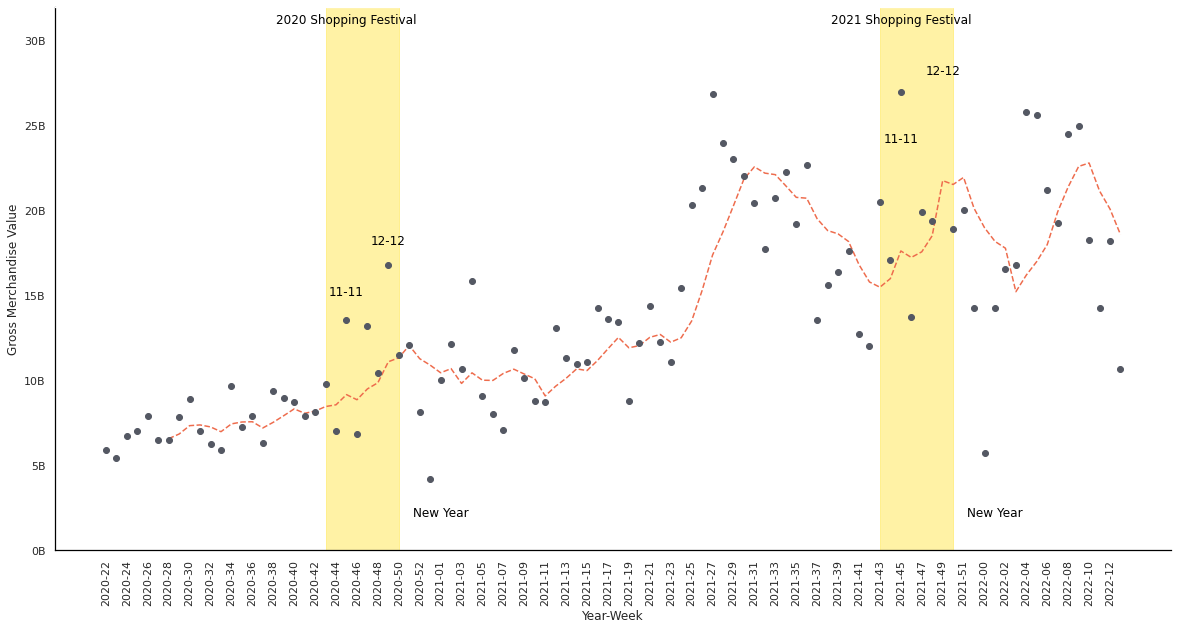

In [5]:
# Figure 4
# set up figures
fig, ax = plt.subplots(figsize = (20,10))
ax.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# prepare data
temp = data_so.groupby('Order_MY')['Value_Taxed'].sum().reset_index(name='SUM')
temp['rol7'] = temp[['Order_MY','SUM']].rolling(7).mean()

# plot data
ax.scatter('Order_MY', 'SUM', color = '#545863', data=temp, zorder=5)
ax.plot('Order_MY', 'rol7', '--', color = '#EE6C4D', data=temp, label='moving average')

# set xtick labels
xlabels=temp['Order_MY']
ax.set_xticks(xlabels[::2])
ax.set_xticklabels(xlabels[::2], rotation=90)

# set ytick labels
ax.set_ylim(ymin=0, ymax=32000000000)
ax.set_yticks(pd.np.linspace(0, 30000000000, 7))
ylabels = ['{:,.0f}'.format(x) + 'B' for x in ax.get_yticks()/1000000000]
ax.set_yticklabels(ylabels);

plt.ylabel('Gross Merchandise Value')
plt.xlabel('Year-Week')

# highlight shopping festival period
plt.axvspan(21, 28, color='#FFE74C', alpha=0.5, zorder=1)
plt.axvspan(74, 81, color='#FFE74C', alpha=0.5, zorder=1)

# add label to highlight 2020 shopping festival
plt.text('2020-45', 31000000000, '2020 Shopping Festival', ha='center', color='black', alpha=1)
plt.text('2020-45', 15000000000, '11-11', color='black', ha='center', alpha=1)
plt.text('2020-49', 18000000000, '12-12', color='black', ha='center', alpha=1)

# add label to highlight 2021 shopping festival
plt.text('2021-45', 31000000000, '2021 Shopping Festival', ha='center', color='black', alpha=1)
plt.text('2021-45', 24000000000, '11-11', color='black', ha='center', alpha=1)
plt.text('2021-49', 28000000000, '12-12', color='black', ha='center', alpha=1)

# add label to highlight lowest new year
plt.text('2021-01', 2000000000, 'New Year', color='black', ha='center', alpha=1)
plt.text('2022-01', 2000000000, 'New Year', color='black', ha='center', alpha=1)

plt.show()

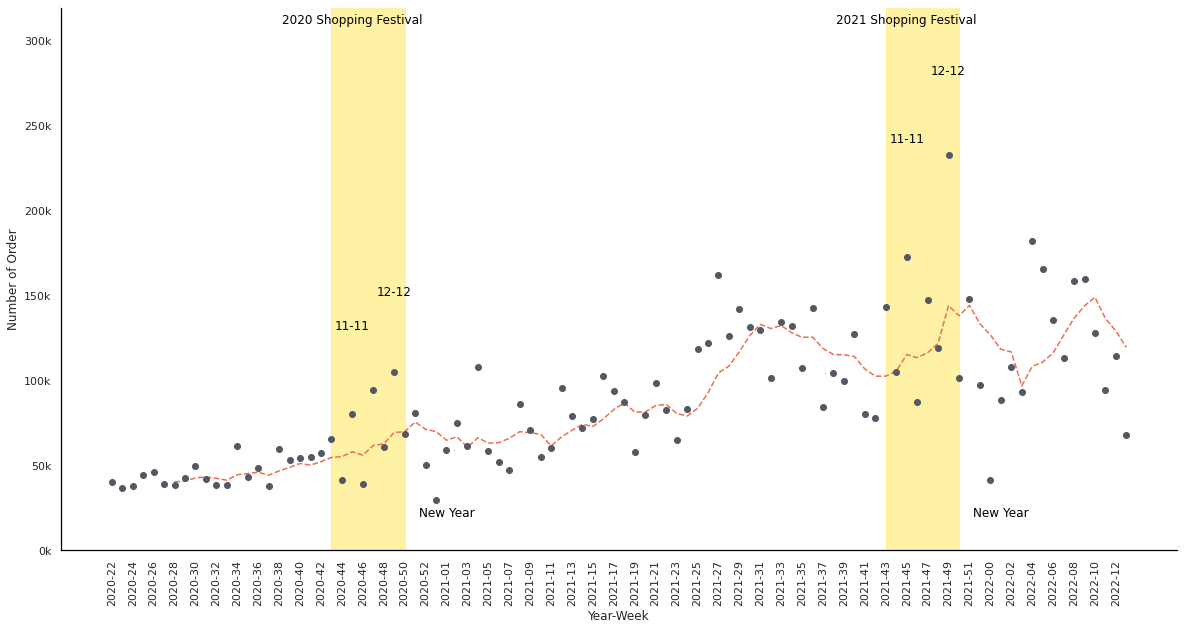

In [6]:
# set up figures
fig, ax = plt.subplots(figsize = (20,10))
ax.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# prepare data
temp = data_so.groupby('Order_MY')['Order_Number'].count().reset_index(name='SUM')
temp['rol7'] = temp[['Order_MY','SUM']].rolling(7).mean()

#plot data
ax.scatter('Order_MY', 'SUM', color = '#545863', data=temp, zorder=5)
ax.plot('Order_MY', 'rol7', '--', color = '#EE6C4D', data=temp, label='moving average')

# set xtick labels
xlabels=temp['Order_MY']
ax.set_xticks(xlabels[::2])
ax.set_xticklabels(xlabels[::2], rotation=90)

# set ytick labels
ax.set_ylim(ymin=0, ymax=320000)
ax.set_yticks(pd.np.linspace(0, 300000, 7))
ylabels = ['{:,.0f}'.format(x) + 'k' for x in ax.get_yticks()/1000]
ax.set_yticklabels(ylabels);

plt.ylabel('Number of Order')
plt.xlabel('Year-Week')

# highlight shopping festival period
plt.axvspan(21, 28, color='#FFE74C', alpha=0.5, zorder=1)
plt.axvspan(74, 81, color='#FFE74C', alpha=0.5, zorder=1)

# add label to highlight 2020 shopping festival
plt.text('2020-45', 310000, '2020 Shopping Festival', ha='center', color='black', alpha=1)
plt.text('2020-45', 130000, '11-11', color='black', ha='center', alpha=1)
plt.text('2020-49', 150000, '12-12', color='black', ha='center', alpha=1)

# add label to highlight 2021 shopping festival
plt.text('2021-45', 310000, '2021 Shopping Festival', ha='center', color='black', alpha=1)
plt.text('2021-45', 240000, '11-11', color='black', ha='center', alpha=1)
plt.text('2021-49', 280000, '12-12', color='black', ha='center', alpha=1)

# add label to highlight lowest new year
plt.text('2021-01', 20000, 'New Year', color='black', ha='center', alpha=1)
plt.text('2022-01', 20000, 'New Year', color='black', ha='center', alpha=1)

plt.show()

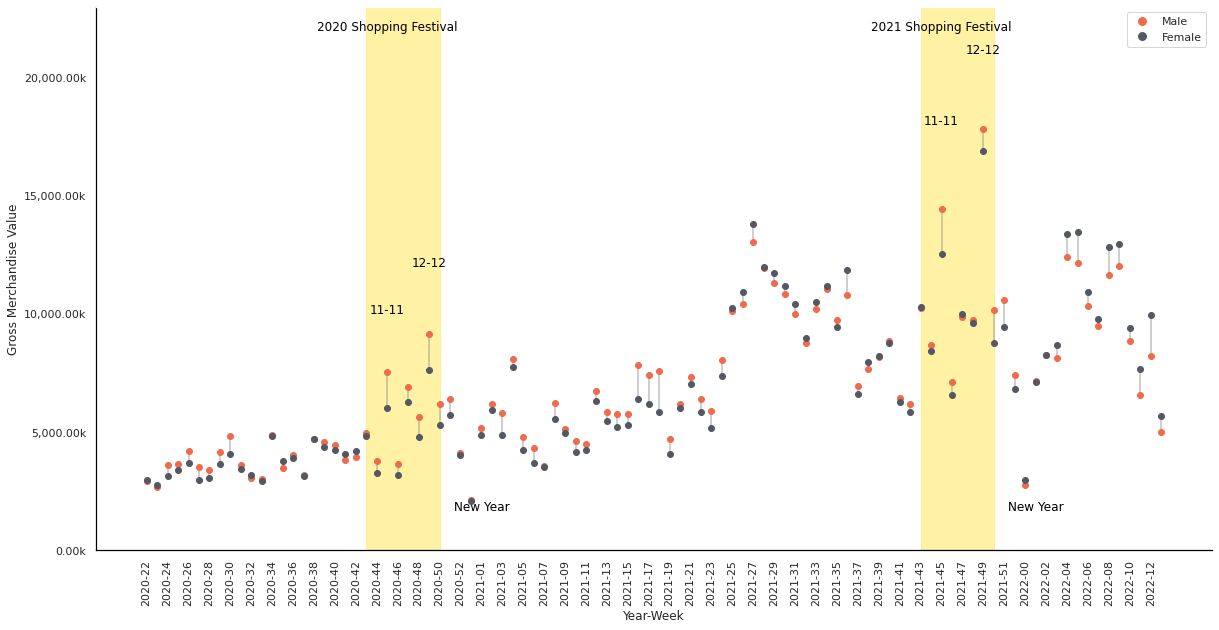

In [7]:
# Figure 5
# set up figures
fig, ax = plt.subplots(figsize = (20,10), sharex=True, sharey=True)
ax.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# prepare data
temp_p = data_so[data_so['Gender'] == 'P']
temp_p = temp_p.groupby('Order_MY')['Value_Taxed'].sum().reset_index(name='SUM')
temp_p['rol7'] = temp_p[['Order_MY','SUM']].rolling(7).mean()

temp_l = data_so[data_so['Gender'] == 'L']
temp_l = temp_l.groupby('Order_MY')['Value_Taxed'].sum().reset_index(name='SUM')
temp_l['rol7'] = temp_l[['Order_MY','SUM']].rolling(7).mean()

#plot data
ax.scatter('Order_MY', 'SUM', color = '#EE6C4D', data=temp_l, zorder=5) # orange male
ax.scatter('Order_MY', 'SUM', color = '#545863', data=temp_p, zorder=5) # orange female

for i in range(0, len(temp_l['Order_MY'])):
    plt.plot([temp_l['Order_MY'][i],temp_p['Order_MY'][i]], [temp_l['SUM'][i],temp_p['SUM'][i]], 'gray', alpha=0.5)

# set xtick labels
xlabels=temp['Order_MY']
ax.set_xticks(xlabels[::2])
ax.set_xticklabels(xlabels[::2], rotation=90)

# set ytick labels
ax.set_ylim(ymin=0, ymax=23000000000)
ax.set_yticks(pd.np.linspace(0, 20000000000, 5))
ylabels = ['{:,.2f}'.format(x) + 'k' for x in ax.get_yticks()/1000000]
ax.set_yticklabels(ylabels);

plt.ylabel('Gross Merchandise Value')
plt.xlabel('Year-Week')

# highlight shopping festival period
plt.axvspan(21, 28, color='#FFE74C', alpha=0.5, zorder=1)
plt.axvspan(74, 81, color='#FFE74C', alpha=0.5, zorder=1)

# add label to highlight 2020 shopping festival
plt.text('2020-45', 22000000000, '2020 Shopping Festival', ha='center', color='black', alpha=1)
plt.text('2020-45', 10000000000, '11-11', color='black', ha='center', alpha=1)
plt.text('2020-49', 12000000000, '12-12', color='black', ha='center', alpha=1)

# add label to highlight 2021 shopping festival
plt.text('2021-45', 22000000000, '2021 Shopping Festival', ha='center', color='black', alpha=1)
plt.text('2021-45', 18000000000, '11-11', color='black', ha='center', alpha=1)
plt.text('2021-49', 21000000000, '12-12', color='black', ha='center', alpha=1)

# add label to highlight lowest new year
plt.text('2021-01', 1700000000, 'New Year', color='black', ha='center', alpha=1)
plt.text('2022-01', 1700000000, 'New Year', color='black', ha='center', alpha=1)

# custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='#EE6C4D', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='#545863', markersize=10),]
ax.legend(legend_elements, ['Male', 'Female'], loc='upper right', facecolor='white')

plt.show()

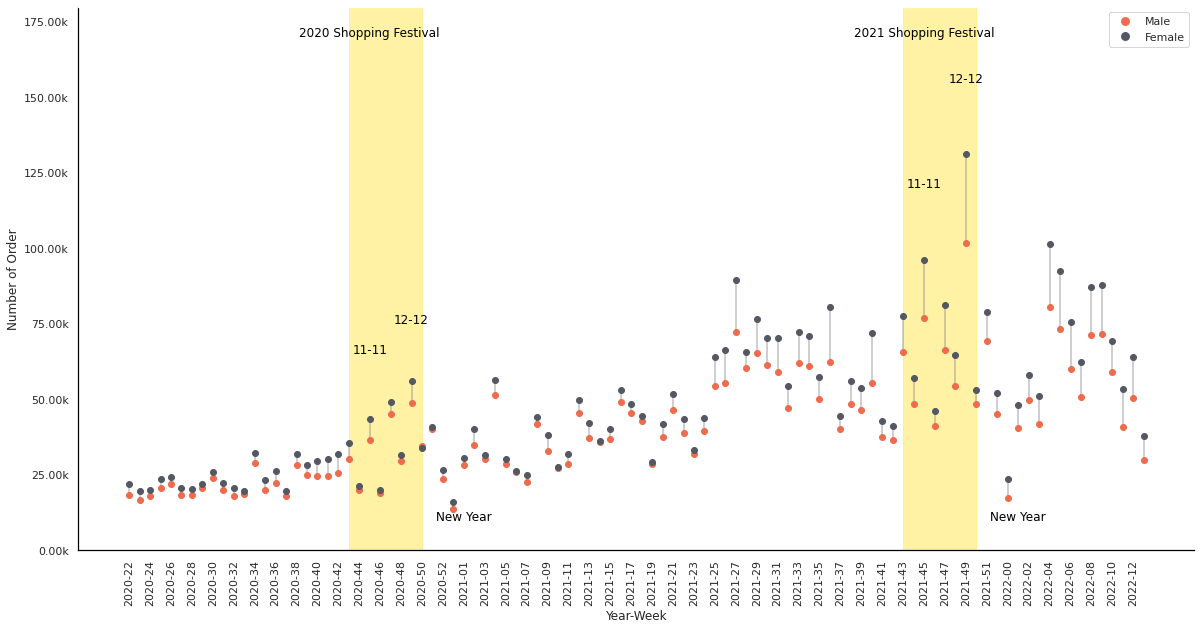

In [8]:
# Figure 6
# set up figures
fig, ax = plt.subplots(figsize = (20,10), sharex=True, sharey=True)
ax.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# prepare data
temp_p = data_so[data_so['Gender'] == 'P']
temp_p = temp_p.groupby('Order_MY')['Order_Number'].count().reset_index(name='SUM')
temp_p['rol7'] = temp_p[['Order_MY','SUM']].rolling(7).mean()

temp_l = data_so[data_so['Gender'] == 'L']
temp_l = temp_l.groupby('Order_MY')['Order_Number'].count().reset_index(name='SUM')
temp_l['rol7'] = temp_l[['Order_MY','SUM']].rolling(7).mean()

#plot data
ax.scatter('Order_MY', 'SUM', color = '#EE6C4D', data=temp_l, zorder=5)
ax.scatter('Order_MY', 'SUM', color = '#545863', data=temp_p, zorder=5)

for i in range(0, len(temp_l['Order_MY'])):
    plt.plot([temp_l['Order_MY'][i],temp_p['Order_MY'][i]], [temp_l['SUM'][i],temp_p['SUM'][i]], 'gray', alpha=0.5)

# set xtick labels
xlabels=temp['Order_MY']
ax.set_xticks(xlabels[::2])
ax.set_xticklabels(xlabels[::2], rotation=90)

# set ytick labels
ax.set_ylim(ymin=0, ymax=180000)
ax.set_yticks(pd.np.linspace(0, 175000, 8))
ylabels = ['{:,.2f}'.format(x) + 'k' for x in ax.get_yticks()/1000]
ax.set_yticklabels(ylabels);

plt.ylabel('Number of Order')
plt.xlabel('Year-Week')

# highlight shopping festival period
plt.axvspan(21, 28, color='#FFE74C', alpha=0.5, zorder=1)
plt.axvspan(74, 81, color='#FFE74C', alpha=0.5, zorder=1)

# add label to highlight 2020 shopping festival
plt.text('2020-45', 170000, '2020 Shopping Festival', ha='center', color='black', alpha=1)
plt.text('2020-45', 65000, '11-11', color='black', ha='center', alpha=1)
plt.text('2020-49', 75000, '12-12', color='black', ha='center', alpha=1)

# add label to highlight 2021 shopping festival
plt.text('2021-45', 170000, '2021 Shopping Festival', ha='center', color='black', alpha=1)
plt.text('2021-45', 120000, '11-11', color='black', ha='center', alpha=1)
plt.text('2021-49', 155000, '12-12', color='black', ha='center', alpha=1)

# add label to highlight lowest new year
plt.text('2021-01', 10000, 'New Year', color='black', ha='center', alpha=1)
plt.text('2022-01', 10000, 'New Year', color='black', ha='center', alpha=1)

# custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='#EE6C4D', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='#545863', markersize=10),]
ax.legend(legend_elements, ['Male', 'Female'], loc='upper right', facecolor='white')


plt.show()

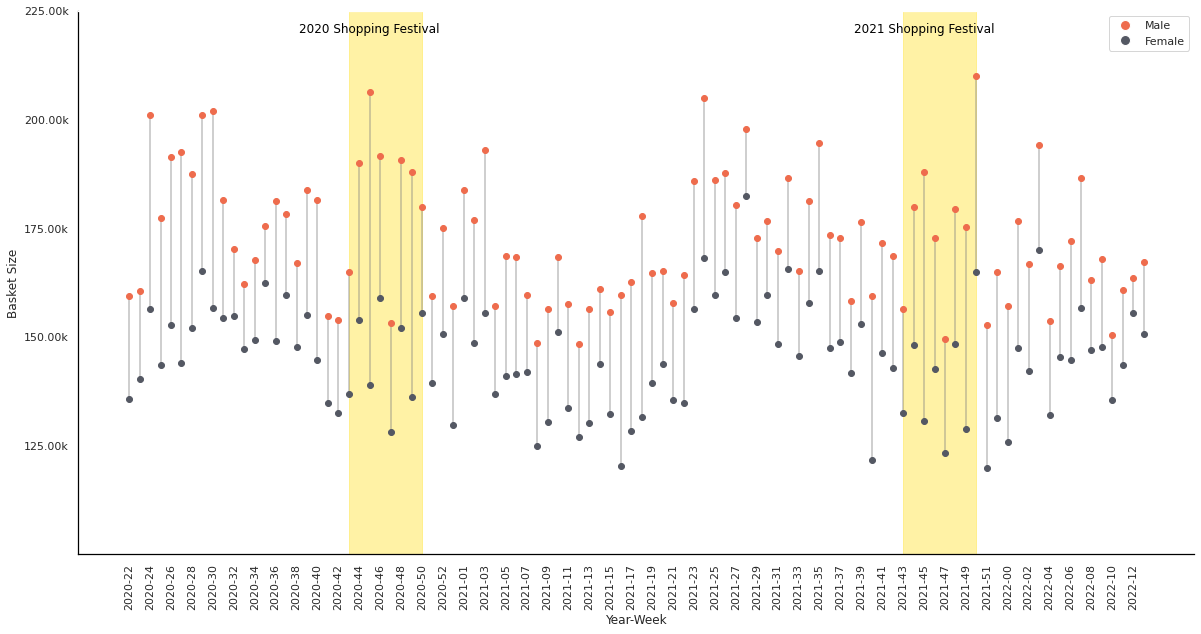

In [9]:
# Figure 7
# set up figures
fig, ax = plt.subplots(figsize = (20,10), sharex=True, sharey=True)
ax.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# prepare data
temp_p = data_so[data_so['Gender'] == 'P']
temp_p = temp_p.groupby('Order_MY').agg({'Order_Number':'count', 'Value_Taxed': 'sum'}).reset_index().rename(columns={'Order_Number':'count', 'Value_Taxed': 'sum'})
temp_p['avg'] = temp_p['sum']/temp_p['count']

temp_l = data_so[data_so['Gender'] == 'L']
temp_l = temp_l.groupby('Order_MY').agg({'Order_Number':'count', 'Value_Taxed': 'sum'}).reset_index().rename(columns={'Order_Number':'count', 'Value_Taxed': 'sum'})
temp_l['avg'] = temp_l['sum']/temp_l['count']

#plot data
ax.scatter('Order_MY', 'avg', color = '#EE6C4D', data=temp_l, zorder=5)
ax.scatter('Order_MY', 'avg', color = '#545863', data=temp_p, zorder=5)

for i in range(0, len(temp_l['Order_MY'])):
    plt.plot([temp_l['Order_MY'][i],temp_p['Order_MY'][i]], [temp_l['avg'][i],temp_p['avg'][i]], 'gray', alpha=0.5)

# set xtick labels
xlabels=temp['Order_MY']
ax.set_xticks(xlabels[::2])
ax.set_xticklabels(xlabels[::2], rotation=90)

# set ytick labels
ax.set_ylim(ymin=100000, ymax=225000)
ax.set_yticks(pd.np.linspace(125000, 225000, 5))
ylabels = ['{:,.2f}'.format(x) + 'k' for x in ax.get_yticks()/1000]
ax.set_yticklabels(ylabels);

plt.ylabel('Basket Size')
plt.xlabel('Year-Week')

# highlight shopping festival period
plt.axvspan(21, 28, color='#FFE74C', alpha=0.5, zorder=1)
plt.axvspan(74, 81, color='#FFE74C', alpha=0.5, zorder=1)

# add label to highlight 2020 shopping festival
plt.text('2020-45', 220000, '2020 Shopping Festival', ha='center', color='black', alpha=1)

# add label to highlight 2021 shopping festival
plt.text('2021-45', 220000, '2021 Shopping Festival', ha='center', color='black', alpha=1)

# custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='#EE6C4D', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='#545863', markersize=10),]
ax.legend(legend_elements, ['Male', 'Female'], loc='upper right', facecolor='white')


plt.show()

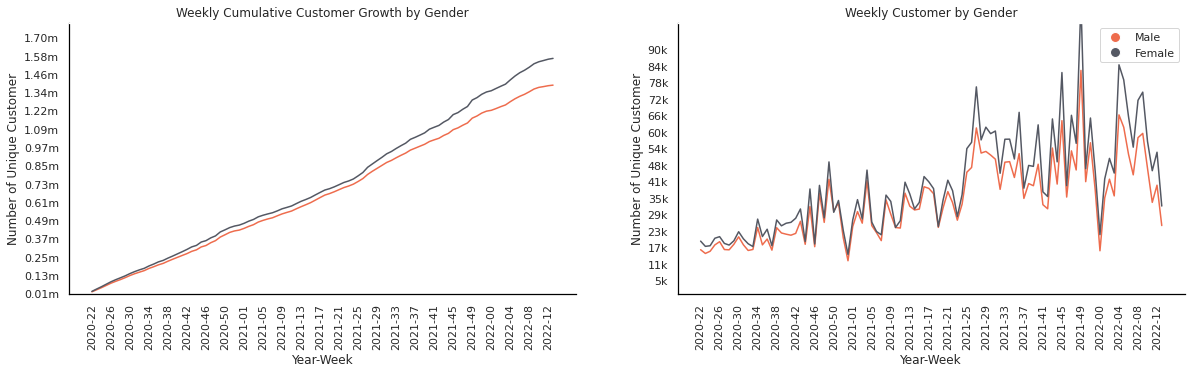

In [10]:
# Figure 8
fig, ax = plt.subplots(1,2,figsize = (20,5))

# ax[0]
#set color
ax[0].set_facecolor('#FFFFFF')
ax[0].spines['bottom'].set_color('black')
ax[0].spines['left'].set_color('black')

# prepare the data
temp_d = data_so.groupby(['Phone', 'Gender', 'Order_MY'])['Order_Number'].count().reset_index(name='cnt').sort_values(by=['Phone','Order_MY'],ascending=True)
temp_d = temp_d.groupby(['Phone']).head(1).sort_values(by=['Order_MY'],ascending=True)
temp_d['base'] = 1
temp_d = temp_d.groupby(['Gender', 'Order_MY'])['base'].sum().reset_index(name='base')
temp_d['cumsum'] = temp_d.groupby('Gender')['base'].cumsum()

# plot data
ax[0].plot('Order_MY', 'cumsum', color = '#EE6C4D', data=temp_d[temp_d['Gender'] == 'L'])
ax[0].plot('Order_MY', 'cumsum', color = '#545863', data=temp_d[temp_d['Gender'] == 'P'])

# set xtick labels
xlabels=temp_d['Order_MY'][temp_d['Gender'] == 'L']
ax[0].set_xticks(xlabels[::4])
ax[0].set_xticklabels(xlabels[::4], rotation=90)

# set ytick labels
ax[0].set_ylim(ymin=0, ymax=1800000)
ax[0].set_yticks(pd.np.linspace(5000, 1700000, 15))
ylabels = ['{:,.2f}'.format(x) + 'm' for x in ax[0].get_yticks()/1000000]
ax[0].set_yticklabels(ylabels);

ax[0].set_title('Weekly Cumulative Customer Growth by Gender')
ax[0].set_ylabel('Number of Unique Customer')
ax[0].set_xlabel('Year-Week')

# ax[1]
#set color
ax[1].set_facecolor('#FFFFFF')
ax[1].spines['bottom'].set_color('black')
ax[1].spines['left'].set_color('black')

# prepare the data
temp_e = data_so.groupby(['Gender', 'Order_MY'])['Phone'].nunique().reset_index(name='cnt').sort_values(by=['Order_MY'],ascending=True)

# plot data
ax[1].plot('Order_MY', 'cnt', color = '#EE6C4D', data=temp_e[temp_e['Gender'] == 'L'])
ax[1].plot('Order_MY', 'cnt', color = '#545863', data=temp_e[temp_e['Gender'] == 'P'])

# set xtick labels
xlabels=temp_e['Order_MY']
ax[1].set_xticks(xlabels[::8])
ax[1].set_xticklabels(xlabels[::8], rotation=90)

# set ytick labels
ax[1].set_ylim(ymin=0, ymax=100000)
ax[1].set_yticks(pd.np.linspace(5000, 90000, 15))
ylabels = ['{:,.0f}'.format(x) + 'k' for x in ax[1].get_yticks()/1000]
ax[1].set_yticklabels(ylabels);

ax[1].set_title('Weekly Customer by Gender')
ax[1].set_ylabel('Number of Unique Customer')
ax[1].set_xlabel('Year-Week')

# custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='#EE6C4D', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='#545863', markersize=10),]
ax[1].legend(legend_elements, ['Male', 'Female'], loc='upper right', facecolor='white')


plt.show()

In [11]:
# prepare data
temp_b = data_so.groupby('Gender').agg({'Order_Number':'count', 'Value_Taxed': 'sum', 'Phone': 'nunique'}).reset_index().rename(columns={'Order_Number':'count', 'Value_Taxed': 'sum', 'Phone': 'cust'})
temp_b['avg'] = temp_b['sum']/temp_b['count']
temp_b['avg_order'] = temp_b['count']/temp_b['cust']

# principal
princ = ['Levis', 'RB', 'Unilever', 'Philips', 'Eiger', 'Blackmores', 'LOreal', 'Softex', 'Mead Johnson', 'Garnier']
tempa = data_so[data_so['Principal'].isin(princ)]

temp_a = tempa.groupby('Principal').agg({'Order_Number':'count', 'Value_Taxed': 'sum', 'Phone': 'nunique'}).reset_index().rename(columns={'Order_Number':'count', 'Value_Taxed': 'sum', 'Phone': 'cust'})
temp_a['avg'] = temp_a['sum']/temp_a['count']
temp_a['avg_order'] = temp_a['count']/temp_a['cust']

temp_p = tempa[tempa['Gender'] == 'P']
temp_p = temp_p.groupby('Principal').agg({'Order_Number':'count', 'Value_Taxed': 'sum', 'Phone': 'nunique'}).reset_index().rename(columns={'Order_Number':'count', 'Value_Taxed': 'sum', 'Phone': 'cust'})
temp_p['avg'] = temp_p['sum']/temp_p['count']
temp_p['avg_order'] = temp_p['count']/temp_p['cust']

temp_l = tempa[tempa['Gender'] == 'L']
temp_l = temp_l.groupby('Principal').agg({'Order_Number':'count', 'Value_Taxed': 'sum', 'Phone': 'nunique'}).reset_index().rename(columns={'Order_Number':'count', 'Value_Taxed': 'sum', 'Phone': 'cust'})
temp_l['avg'] = temp_l['sum']/temp_l['count']
temp_l['avg_order'] = temp_l['count']/temp_l['cust']

# province
prov = ['DKI Jakarta', 'Jawa Barat', 'Banten', 'Jawa Timur', 'Jawa Tengah']
tempb = data_so[data_so['Province'].isin(prov)]

temp_ab = tempb.groupby('Principal').agg({'Order_Number':'count', 'Value_Taxed': 'sum', 'Phone': 'nunique'}).reset_index().rename(columns={'Order_Number':'count', 'Value_Taxed': 'sum', 'Phone': 'cust'})
temp_ab['avg'] = temp_a['sum']/temp_a['count']
temp_ab['avg_order'] = temp_a['count']/temp_a['cust']

temp_pb = tempb[tempb['Gender'] == 'P']
temp_pb = temp_pb.groupby('Province').agg({'Order_Number':'count', 'Value_Taxed': 'sum', 'Phone': 'nunique'}).reset_index().rename(columns={'Order_Number':'count', 'Value_Taxed': 'sum', 'Phone': 'cust'})
temp_pb['avg'] = temp_pb['sum']/temp_pb['count']
temp_pb['avg_order'] = temp_pb['count']/temp_pb['cust']

temp_lb = tempb[tempb['Gender'] == 'L']
temp_lb = temp_lb.groupby('Province').agg({'Order_Number':'count', 'Value_Taxed': 'sum', 'Phone': 'nunique'}).reset_index().rename(columns={'Order_Number':'count', 'Value_Taxed': 'sum', 'Phone': 'cust'})
temp_lb['avg'] = temp_lb['sum']/temp_lb['count']
temp_lb['avg_order'] = temp_lb['count']/temp_lb['cust']

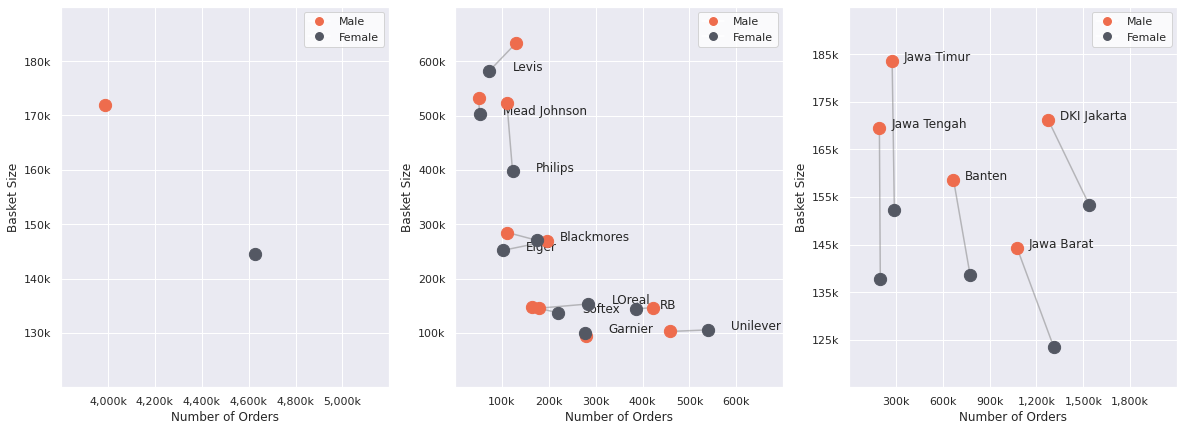

In [12]:
# Figure 9
# set up figures
fig, ax = plt.subplots(1,3,figsize = (20,7))

#plot data
# ax[0]
ax[0].scatter('count', 'avg', color='#EE6C4D', s=150, data=temp_b[temp_b['Gender'] == 'L'], zorder=5)
ax[0].scatter('count', 'avg', color='#545863', s=150, data=temp_b[temp_b['Gender'] == 'P'], zorder=5)

# set xtick labels
ax[0].set_xlim(xmin=3800000, xmax=5200000)
ax[0].set_xticks(pd.np.linspace(4000000, 5000000, 6))
xlabels = ['{:,.0f}'.format(x) + 'k' for x in ax[0].get_xticks()/1000]
ax[0].set_xticklabels(xlabels);

# set ytick labels
ax[0].set_ylim(ymin=120000, ymax=190000)
ax[0].set_yticks(pd.np.linspace(130000, 180000, 6))
ylabels = ['{:,.0f}'.format(x) + 'k' for x in ax[0].get_yticks()/1000]
ax[0].set_yticklabels(ylabels);

ax[0].set_ylabel('Basket Size')
ax[0].set_xlabel('Number of Orders')

# ax[1]
ax[1].scatter('count', 'avg', color = '#EE6C4D', s=150, data=temp_l, zorder=5)
ax[1].scatter('count', 'avg', color = '#545863', s=150, data=temp_p, zorder=5)

for i in range(0, len(temp_l['count'])):
    ax[1].plot([temp_l['count'][i],temp_p['count'][i]], [temp_l['avg'][i],temp_p['avg'][i]], 'gray', alpha=0.5)

label_point(temp_p['count'], temp_p['avg'], temp_l['Principal'], 50000, ax[1])

# set xtick labels
ax[1].set_xlim(xmin=0, xmax=700000)
ax[1].set_xticks(pd.np.linspace(100000, 600000, 6))
xlabels = ['{:,.0f}'.format(x) + 'k' for x in ax[1].get_xticks()/1000]
ax[1].set_xticklabels(xlabels);

# set ytick labels
ax[1].set_ylim(ymin=0, ymax=700000)
ax[1].set_yticks(pd.np.linspace(100000, 600000, 6))
ylabels = ['{:,.0f}'.format(x) + 'k' for x in ax[1].get_yticks()/1000]
ax[1].set_yticklabels(ylabels);

ax[1].set_ylabel('Basket Size')
ax[1].set_xlabel('Number of Orders')

# ax[2]
ax[2].scatter('count', 'avg', color = '#EE6C4D', s=150, data=temp_lb, zorder=5)
ax[2].scatter('count', 'avg', color = '#545863', s=150, data=temp_pb, zorder=5)

for i in range(0, len(temp_lb['count'])):
    ax[2].plot([temp_lb['count'][i],temp_pb['count'][i]], [temp_lb['avg'][i],temp_pb['avg'][i]], 'gray', alpha=0.5)

label_point(temp_lb['count'], temp_lb['avg'], temp_lb['Province'], 75000, ax[2])

# set xtick labels
ax[2].set_xlim(xmin=0, xmax=2100000)
ax[2].set_xticks(pd.np.linspace(300000, 1800000, 6))
xlabels = ['{:,.0f}'.format(x) + 'k' for x in ax[2].get_xticks()/1000]
ax[2].set_xticklabels(xlabels);

# set ytick labels
ax[2].set_ylim(ymin=115000, ymax=195000)
ax[2].set_yticks(pd.np.linspace(125000, 185000, 7))
ylabels = ['{:,.0f}'.format(x) + 'k' for x in ax[2].get_yticks()/1000]
ax[2].set_yticklabels(ylabels);

ax[2].set_ylabel('Basket Size')
ax[2].set_xlabel('Number of Orders')

# custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='#EE6C4D', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='#545863', markersize=10),]
ax[0].legend(legend_elements, ['Male', 'Female'], loc='upper right', facecolor='white')

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='#EE6C4D', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='#545863', markersize=10),]
ax[1].legend(legend_elements, ['Male', 'Female'], loc='upper right', facecolor='white')


from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='#EE6C4D', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='#545863', markersize=10),]
ax[2].legend(legend_elements, ['Male', 'Female'], loc='upper right', facecolor='white')


plt.show()

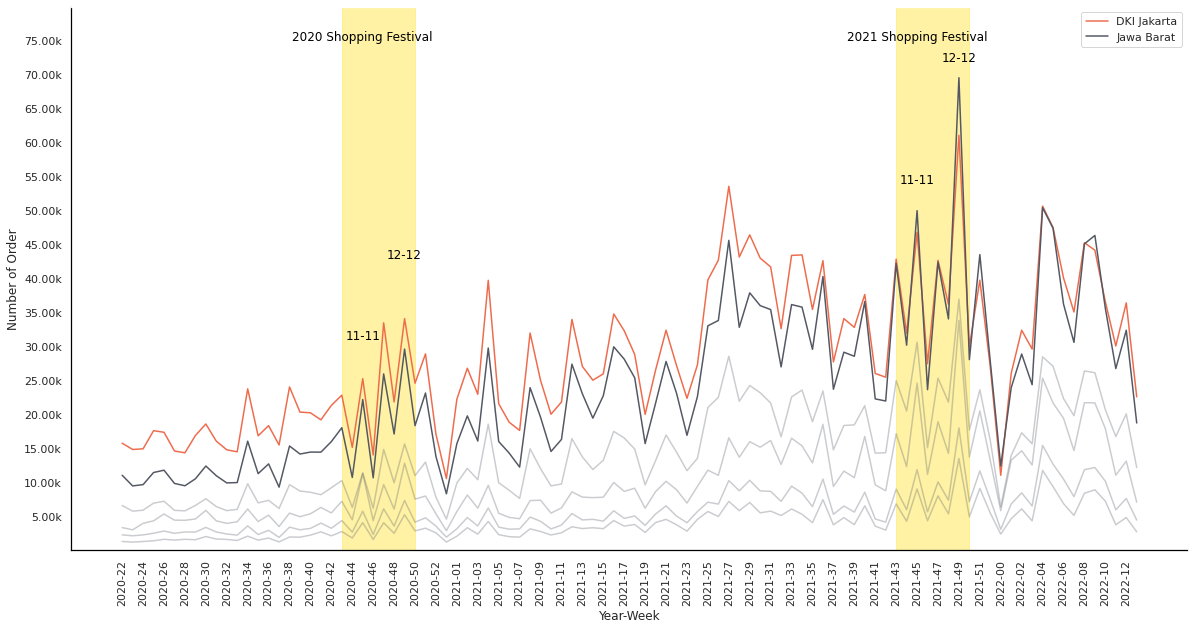

In [13]:
# set up figures
fig, ax = plt.subplots(figsize = (20,10), sharex=True, sharey=True)
ax.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# prepare data
province = ['DKI Jakarta', 'Jawa Barat', 'Banten', 'Jawa Timur', 'Jawa Tengah']

temp_1 = data_so[data_so['Province'] == 'DKI Jakarta']
temp_1 = temp_1.groupby('Order_MY')['Order_Number'].count().reset_index(name='SUM')
temp_1['rol7'] = temp_1[['Order_MY','SUM']].rolling(7).mean()

temp_2 = data_so[data_so['Province'] == 'Jawa Barat']
temp_2 = temp_2.groupby('Order_MY')['Order_Number'].count().reset_index(name='SUM')
temp_2['rol7'] = temp_2[['Order_MY','SUM']].rolling(7).mean()

temp_3 = data_so[data_so['Province'] == 'Banten']
temp_3 = temp_3.groupby('Order_MY')['Order_Number'].count().reset_index(name='SUM')
temp_3['rol7'] = temp_3[['Order_MY','SUM']].rolling(7).mean()

temp_4 = data_so[data_so['Province'] == 'Jawa Timur']
temp_4 = temp_4.groupby('Order_MY')['Order_Number'].count().reset_index(name='SUM')
temp_4['rol7'] = temp_4[['Order_MY','SUM']].rolling(7).mean()

temp_5 = data_so[data_so['Province'] == 'Jawa Tengah']
temp_5 = temp_5.groupby('Order_MY')['Order_Number'].count().reset_index(name='SUM')
temp_5['rol7'] = temp_5[['Order_MY','SUM']].rolling(7).mean()

temp_6 = data_so[~data_so['Province'].isin(province)]
temp_6 = temp_6.groupby('Order_MY')['Order_Number'].count().reset_index(name='SUM')
temp_6['rol7'] = temp_6[['Order_MY','SUM']].rolling(7).mean()

#plot data
ax.plot('Order_MY', 'SUM', color = '#EE6C4D', data=temp_1)
ax.plot('Order_MY', 'SUM', color = '#545863', data=temp_2)
ax.plot('Order_MY', 'SUM', color = '#545863', data=temp_3, alpha=0.3)
ax.plot('Order_MY', 'SUM', color = '#545863', data=temp_4, alpha=0.3)
ax.plot('Order_MY', 'SUM', color = '#545863', data=temp_5, alpha=0.3)
ax.plot('Order_MY', 'SUM', color = '#545863', data=temp_6, alpha=0.3)

# set xtick labels
xlabels=temp_1['Order_MY']
ax.set_xticks(xlabels[::2])
ax.set_xticklabels(xlabels[::2], rotation=90)

# set ytick labels
ax.set_ylim(ymin=0, ymax=80000)
ax.set_yticks(pd.np.linspace(5000, 75000, 15))
ylabels = ['{:,.2f}'.format(x) + 'k' for x in ax.get_yticks()/1000]
ax.set_yticklabels(ylabels);

plt.ylabel('Number of Order')
plt.xlabel('Year-Week')

# highlight shopping festival period
plt.axvspan(21, 28, color='#FFE74C', alpha=0.5, zorder=1)
plt.axvspan(74, 81, color='#FFE74C', alpha=0.5, zorder=1)

# add label to highlight 2020 shopping festival
plt.text('2020-45', 75000, '2020 Shopping Festival', ha='center', color='black', alpha=1)
plt.text('2020-45', 31000, '11-11', color='black', ha='center', alpha=1)
plt.text('2020-49', 43000, '12-12', color='black', ha='center', alpha=1)

# add label to highlight 2021 shopping festival
plt.text('2021-45', 75000, '2021 Shopping Festival', ha='center', color='black', alpha=1)
plt.text('2021-45', 54000, '11-11', color='black', ha='center', alpha=1)
plt.text('2021-49', 72000, '12-12', color='black', ha='center', alpha=1)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='#EE6C4D', label='Scatter'),
                   Line2D([0], [0], color='#545863', label='Scatter'),]
ax.legend(legend_elements, ['DKI Jakarta', 'Jawa Barat'], loc='upper right', facecolor='white')

plt.show()

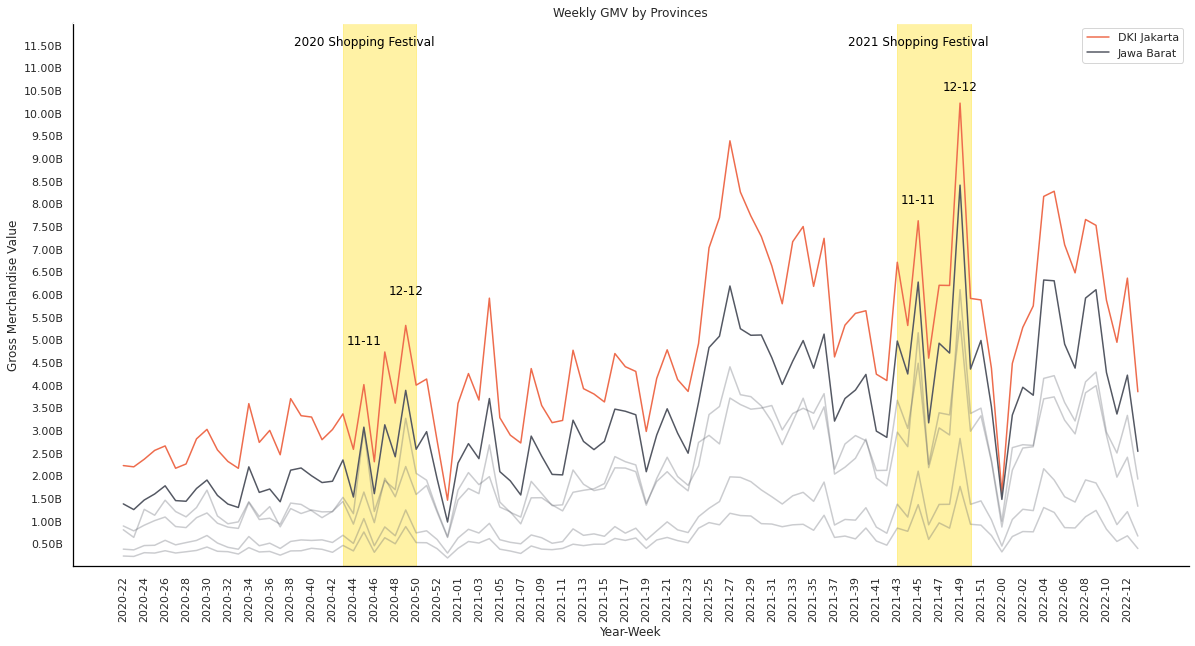

In [14]:
# Figure 10
# set up figures
fig, ax = plt.subplots(figsize = (20,10), sharex=True, sharey=True)
ax.set_facecolor('#FFFFFF')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

# prepare data
province = ['DKI Jakarta', 'Jawa Barat', 'Banten', 'Jawa Timur', 'Jawa Tengah']

temp_1 = data_so[data_so['Province'] == 'DKI Jakarta']
temp_1 = temp_1.groupby('Order_MY')['Value_Taxed'].sum().reset_index(name='SUM')
temp_1['rol7'] = temp_1[['Order_MY','SUM']].rolling(7).mean()

temp_2 = data_so[data_so['Province'] == 'Jawa Barat']
temp_2 = temp_2.groupby('Order_MY')['Value_Taxed'].sum().reset_index(name='SUM')
temp_2['rol7'] = temp_2[['Order_MY','SUM']].rolling(7).mean()

temp_3 = data_so[data_so['Province'] == 'Banten']
temp_3 = temp_3.groupby('Order_MY')['Value_Taxed'].sum().reset_index(name='SUM')
temp_3['rol7'] = temp_3[['Order_MY','SUM']].rolling(7).mean()

temp_4 = data_so[data_so['Province'] == 'Jawa Timur']
temp_4 = temp_4.groupby('Order_MY')['Value_Taxed'].sum().reset_index(name='SUM')
temp_4['rol7'] = temp_4[['Order_MY','SUM']].rolling(7).mean()

temp_5 = data_so[data_so['Province'] == 'Jawa Tengah']
temp_5 = temp_5.groupby('Order_MY')['Value_Taxed'].sum().reset_index(name='SUM')
temp_5['rol7'] = temp_5[['Order_MY','SUM']].rolling(7).mean()

temp_6 = data_so[~data_so['Province'].isin(province)]
temp_6 = temp_6.groupby('Order_MY')['Value_Taxed'].sum().reset_index(name='SUM')
temp_6['rol7'] = temp_6[['Order_MY','SUM']].rolling(7).mean()

#plot data
ax.plot('Order_MY', 'SUM', color = '#EE6C4D', data=temp_1)
ax.plot('Order_MY', 'SUM', color = '#545863', data=temp_2)
ax.plot('Order_MY', 'SUM', color = '#545863', data=temp_3, alpha=0.3)
ax.plot('Order_MY', 'SUM', color = '#545863', data=temp_4, alpha=0.3)
ax.plot('Order_MY', 'SUM', color = '#545863', data=temp_5, alpha=0.3)
ax.plot('Order_MY', 'SUM', color = '#545863', data=temp_6, alpha=0.3)

# set xtick labels
xlabels=temp_1['Order_MY']
ax.set_xticks(xlabels[::2])
ax.set_xticklabels(xlabels[::2], rotation=90)

# set ytick labels
ax.set_ylim(ymin=0, ymax=12000000000)
ax.set_yticks(pd.np.linspace(500000000, 11500000000, 23))
ylabels = ['{:,.2f}'.format(x) + 'B' for x in ax.get_yticks()/1000000000]
ax.set_yticklabels(ylabels);

plt.title('Weekly GMV by Provinces')
plt.ylabel('Gross Merchandise Value')
plt.xlabel('Year-Week')

plt.axvspan(21, 28, color='#FFE74C', alpha=0.5, zorder=1)
plt.axvspan(74, 81, color='#FFE74C', alpha=0.5, zorder=1)

# add label to highlight 2020 shopping festival
plt.text('2020-45', 11500000000, '2020 Shopping Festival', ha='center', color='black', alpha=1)
plt.text('2020-45', 4900000000, '11-11', color='black', ha='center', alpha=1)
plt.text('2020-49', 6000000000, '12-12', color='black', ha='center', alpha=1)

# add label to highlight 2021 shopping festival
plt.text('2021-45', 11500000000, '2021 Shopping Festival', ha='center', color='black', alpha=1)
plt.text('2021-45', 8000000000, '11-11', color='black', ha='center', alpha=1)
plt.text('2021-49', 10500000000, '12-12', color='black', ha='center', alpha=1)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='#EE6C4D', label='Scatter'),
                   Line2D([0], [0], color='#545863', label='Scatter'),]
ax.legend(legend_elements, ['DKI Jakarta', 'Jawa Barat'], loc='upper right', facecolor='white')

plt.show()

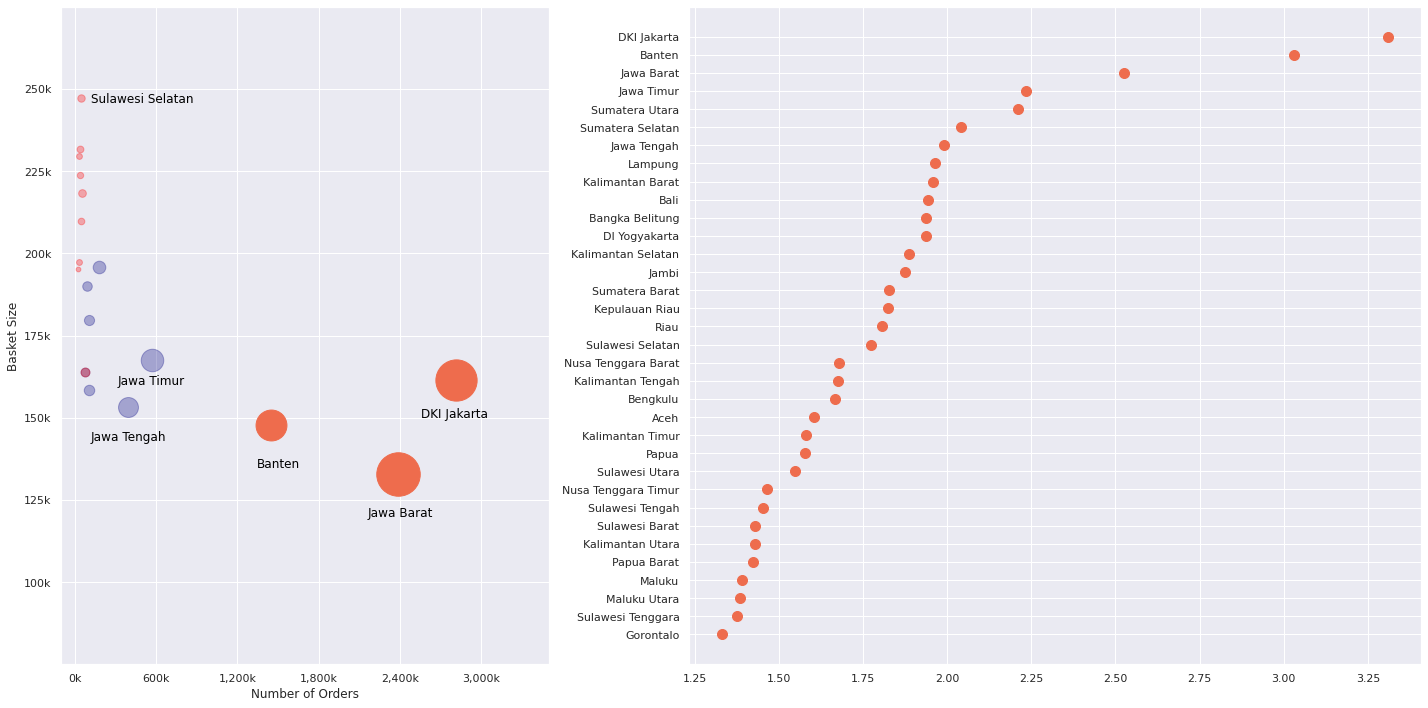

In [15]:
# Figure 11
# set up figures
fig, ax = plt.subplots(1,2,figsize = (20,10), gridspec_kw={'width_ratios': [1,1.5]})

#plot data
temp_b = data_so.groupby('Province').agg({'Order_Number':'count', 'Value_Taxed': 'sum', 'Phone': 'nunique'}).reset_index().rename(columns={'Order_Number':'count', 'Value_Taxed': 'sum', 'Phone': 'cust'})
temp_b['avg'] = temp_b['sum']/temp_b['count']
temp_b['avg_order'] = temp_b['count']/temp_b['cust']

# ax[0]
ax[0].scatter('count', 'avg', color='#EE6C4D', s=temp_b['cust'][temp_b['Province']=='DKI Jakarta']/500, data=temp_b[temp_b['Province'] == 'DKI Jakarta'], zorder=6)
ax[0].scatter('count', 'avg', color='#EE6C4D', s=temp_b['cust'][temp_b['Province']=='Jawa Barat']/500, data=temp_b[temp_b['Province'] == 'Jawa Barat'], zorder=6)
ax[0].scatter('count', 'avg', color='#EE6C4D', s=temp_b['cust'][temp_b['Province']=='Banten']/500, data=temp_b[temp_b['Province'] == 'Banten'], zorder=6)

top10 = ['Jawa Timur', 'Jawa Tengah', 'Sumatera Utara', 'DI Yogyakarta', 'Sumatera Selatan', 'Bali', 'Lampung']
for i,x in enumerate(top10):
    ax[0].scatter('count', 'avg', color='navy', s=temp_b['cust'][temp_b['Province']==x]/500, data=temp_b[temp_b['Province'] == x], alpha=0.3, zorder=5)

top20 = ['Lampung', 'Riau', 'Sulawesi Selatan', 'Sumatera Barat', 'Kalimantan Barat', 'Kepulauan Riau', 'Jambi', 'Kalimantan Selatan', 'Kalimantan Timur', 'Bangka Belitung']
for i,x in enumerate(top20):
    ax[0].scatter('count', 'avg', color='red', s=temp_b['cust'][temp_b['Province']==x]/500, data=temp_b[temp_b['Province'] == x], alpha=0.3, zorder=5)

ax[0].text(2800000, 150000, 'DKI Jakarta', ha='center', color='black', alpha=1)
ax[0].text(2400000, 120000, 'Jawa Barat', ha='center', color='black', alpha=1)
ax[0].text(1500000, 135000, 'Banten', ha='center', color='black', alpha=1)

ax[0].text(565000, 160000, 'Jawa Timur', ha='center', color='black', alpha=1)
ax[0].text(395000, 143000, 'Jawa Tengah', ha='center', color='black', alpha=1)

ax[0].text(500000, 246000, 'Sulawesi Selatan', ha='center', color='black', alpha=1)
    
# set xtick labels
ax[0].set_xlim(xmin=-100000, xmax=3500000)
ax[0].set_xticks(pd.np.linspace(0, 3000000, 6))
xlabels = ['{:,.0f}'.format(x) + 'k' for x in ax[0].get_xticks()/1000]
ax[0].set_xticklabels(xlabels);

# set ytick labels
ax[0].set_ylim(ymin=75000, ymax=275000)
ax[0].set_yticks(pd.np.linspace(100000, 250000, 7))
ylabels = ['{:,.0f}'.format(x) + 'k' for x in ax[0].get_yticks()/1000]
ax[0].set_yticklabels(ylabels);

ax[0].set_ylabel('Basket Size')
ax[0].set_xlabel('Number of Orders')

# ax[0]
temp_ax2 = temp_b.sort_values(by='avg_order', ascending=True)
temp_ax2 = temp_ax2[temp_ax2['Province']!='province_name_unclear']
ax[1].scatter('avg_order', 'Province', s= 100, color='#EE6C4D', data=temp_ax2, zorder=6)

plt.tight_layout()
plt.show()

In [16]:
data_so.to_csv('final_data_so.csv', index=False)